# 캘리포니아 주택 가격 예측

### 중간 주택 가격을 예측해야 한다!!
------
- 지도학습
- 값 예측: 전형적인 회귀 문제 (예측에 사용할 특성이 여러개: 다중 회귀)
- 각 구역마다 하나의 값을 예측하므로 ```단변량 회귀```
- 일반적인 배치 학습
- 회귀 문제의 전형적인 성능 지표인 ```평균 제곱근 오차 (RMSE)```를 사용
  - 이상치가 매우 드물 때 사용
  - 이상치가 많은 경우는 ```평균 절대 오차 (MSE)```를 사용

#### download

In [6]:
# !pip3 install pandas
# !pip3 install scikit-learn
# !pip3 install matplotlib

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/f2/b4/c273b046e0f14e76ec33fdce82d70ddce1c796aaabadf436b3b8bf01ffb5/scikit_learn-1.3.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/1d/77/5e660d211906becd9f8e13e00d828f5e68b5e66d9b956f4646bb4882c68e/scipy-1.11.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 3.1 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/1

# 데이터 가져오기

### 데이터 로드 & 데이터 성격 파악

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

- ocean_proximity 피쳐 빼고 다 숫자형
    - 범주형 데이터일 것이다.
    - value_counts
- total_bedrooms에 대한 null 값 처리를 해야줘야함.

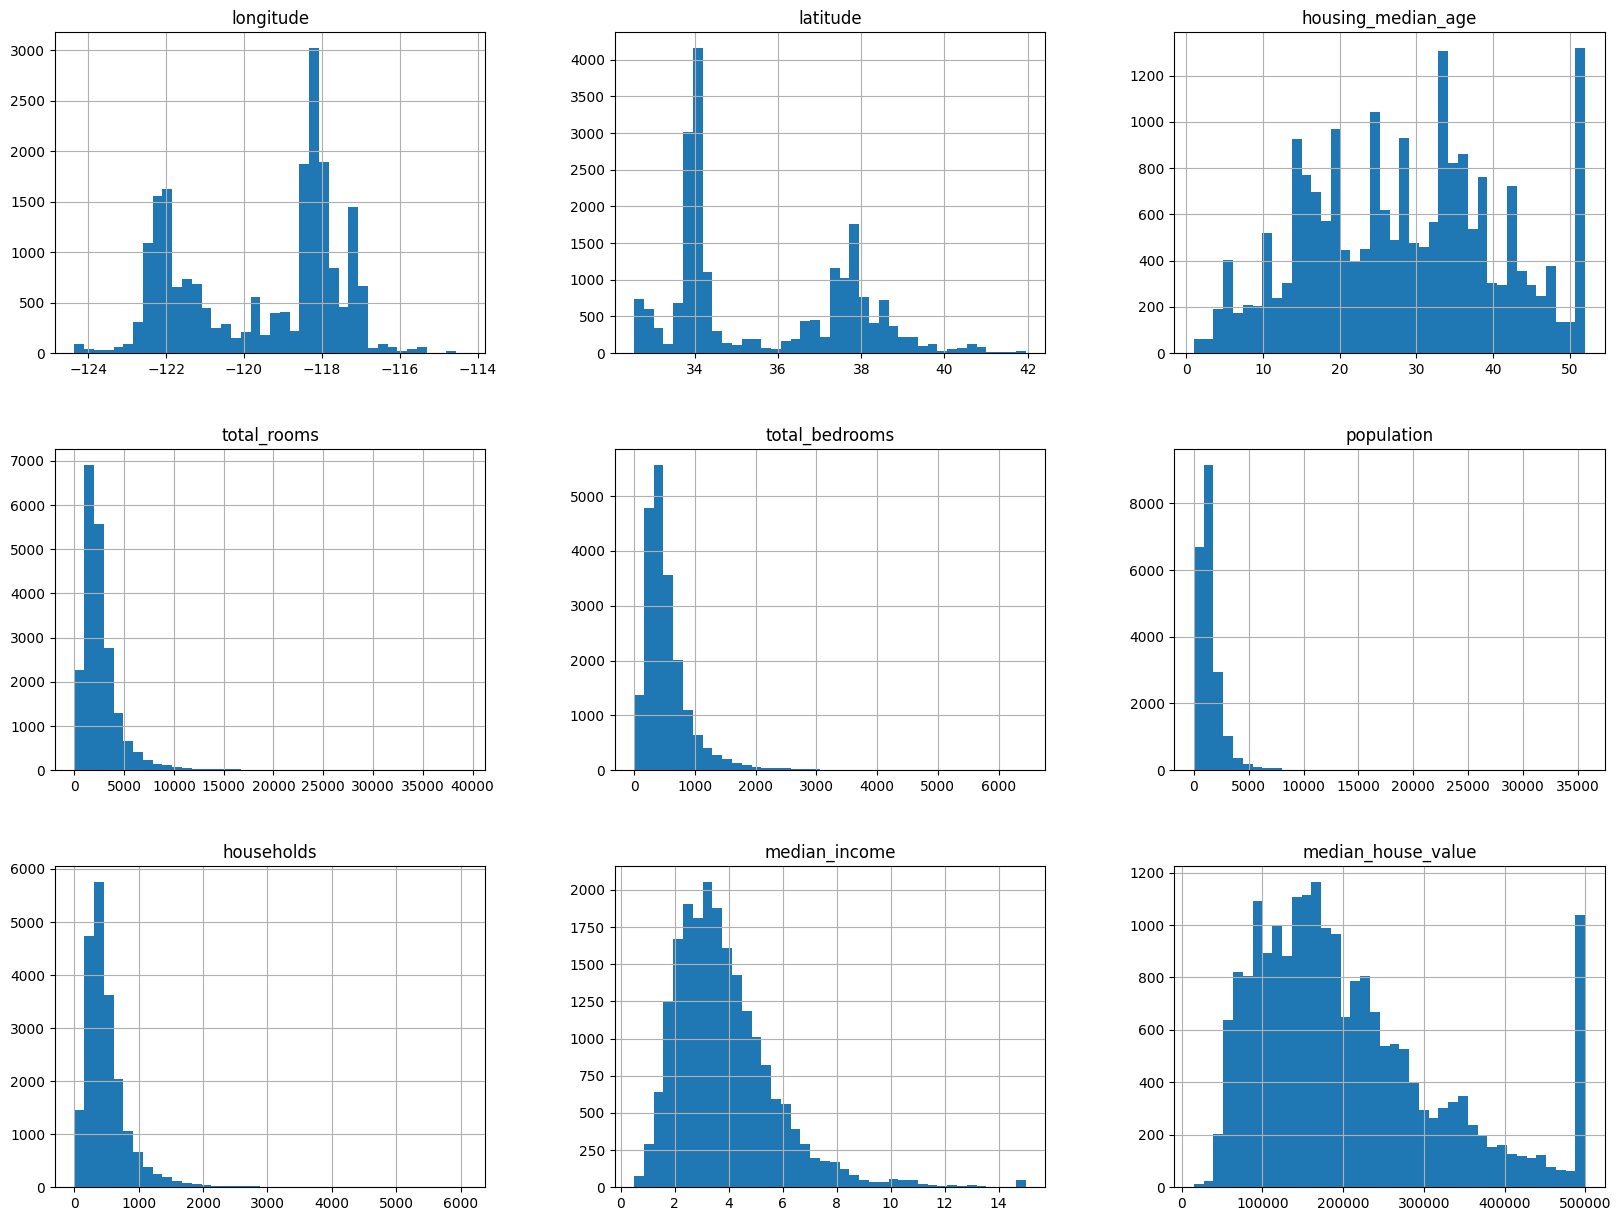

In [20]:
import matplotlib.pyplot as plt
df.hist(bins = 40, figsize = (20,15)) # bin 막대 가로 길이
plt.show()

- median_income 의 데이터가 US달러가 아닌 점.
- median_house_value 최소, 최대값을 한정 해야한다.
  - 한계값 밖의 구역에 대한 정확한 레이블을 구합니다
  - 훈련 세트에서 이런 구역을 제거합니다. (이상치에 대한 예측은 평과 결과가 매우 나쁠 것이므로, 테스트 데이터에서도 제거가 필요하다.)
- 특성들의 스케일이 서로 많이 다르다
  - 이 부분도 처리를 해줘야 한다.
  - 히스토그램의 꼬리 오른쪽으로 뻗어있는 특성이 있다.
    - 나중에 이런 특성들을 종 모양의 분포가 되도록 변형시켜야 한다.

### 테스트 데이터 분리

#### 순수한 무작위 샘플링 방식
- 데이터셋이 충분히 크다면 문제가 없지만 그렇지 않다면 샘플링 편향이 생길 가능성이 크다.

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
# 난수 초기값 설정을 할 수 있는 random_state, 
# 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스 기반으로 나눌 수 있다.

#### 계층적 샘플링
- 테스트 세트가 전체 인구를 대표하도록 각 계층에서 올바른 수의 샘플을 추출한다.
- 계층별로 데이터셋에 충분한 샘플 수가 있어야 한다.

In [6]:
import numpy as np
df['income_cat'] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

<Axes: >

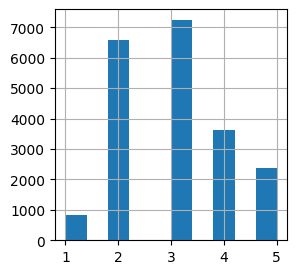

In [58]:
df['income_cat'].hist(figsize=(3,3))

##### 소득 카테고리를 기반으로 계층 샘플링

train_test_set에 stratify이게 그건가..?

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [8]:
strat_test_set['income_cat'].value_counts().sort_index()/ len(strat_test_set)

income_cat
1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: count, dtype: float64

##### 무작위 샘플링이랑 비교

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
test_set['income_cat'].value_counts().sort_index()/ len(strat_test_set)

income_cat
1    0.040213
2    0.324370
3    0.358527
4    0.167393
5    0.109496
Name: count, dtype: float64

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화

In [13]:
df_train = strat_train_set.copy()

### 지리적 데이터

<Axes: xlabel='longitude', ylabel='latitude'>

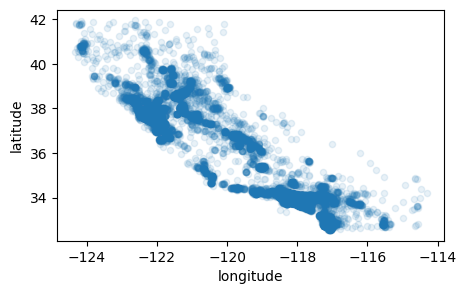

In [77]:
df_train.plot(kind='scatter', x='longitude',y = 'latitude',alpha  = 0.1,figsize=(5,3))
# alpha 이면 밀집된 영역을 더 잘 보여준다

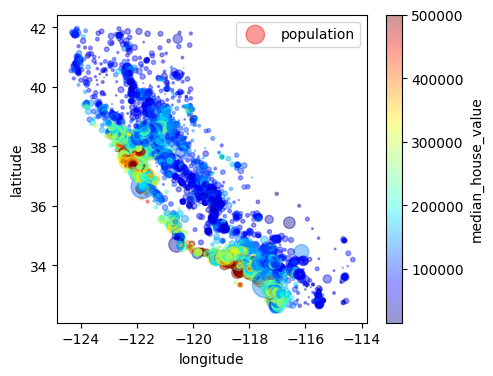

In [79]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df["population"]/100, label="population", figsize=(5,4),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

- s: 원의 반지름은 구역의 인구
- c: 색상은 가격
- cmap: 파란색(낮은 가격)에서 빨간색(높은 가격)까지 범위를 가지는 jet을 사용

- 주택 가격은 지역과 인구 밀도에 관련이 매우 크다는 것을 알 수 있다.
  - 군집 알고리즘을 사용하여 주요 군집을 찾고 군집의 중심까지의 거리를 재는 특성을 추가할 수 있다.

### 상관관계 조사

#### 방법 1. corr 메서드 이용

In [15]:
corr_matrix = df_train[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']].corr()

In [92]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

#### 방법 2. 특성 사이의 산점도 그리기

In [16]:
from pandas.plotting import scatter_matrix

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

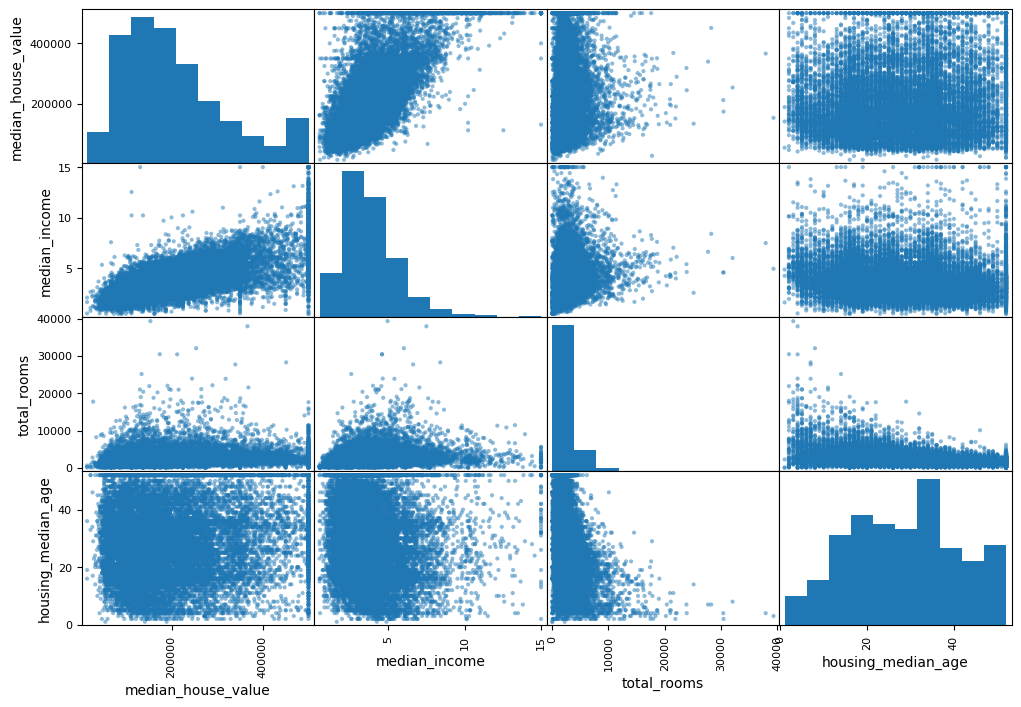

In [21]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(df_train[attributes], figsize=(12, 8))

- medain_house_value를 예측하는데 가장 유용할 것 같은 것은 median_income 이다.

<Axes: xlabel='median_income', ylabel='median_house_value'>

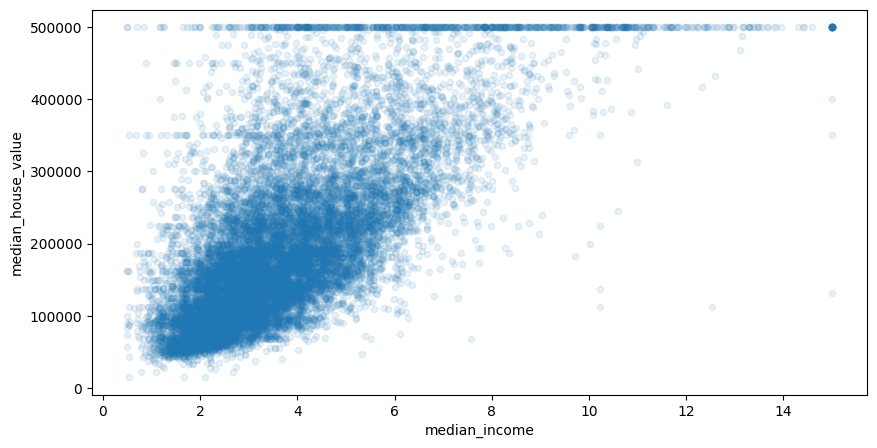

In [27]:
df_train.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1,figsize=(10,5))

- 상관관계가 매우 강하다. (위쪽으로 올라가는 경향을 확인 가능하다.)
- 포인트들이 멀리 퍼져있지 않다.
    - 회귀?
- 가격 제한값이 수평선으로 나타남(500,000 , 450,000 , 350,000 등)
  - 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거해야한다.

### 특성 조합으로 실험

In [29]:
df_train["rooms_per_household"] = df_train["total_rooms"]/df_train["households"]
df_train["bedrooms_per_room"] = df_train["total_bedrooms"]/df_train["total_rooms"]
df_train["population_per_household"]=df_train["population"]/df_train["households"]

- 특정 구역의 방 개수는 얼마나 많은 가구 수가 있는지 모른다면 유용하지 않다.
  - 진짜 필요한 것은 가구당 방 개수이다

In [33]:
corr_matrix = df_train[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value','rooms_per_household','bedrooms_per_room','population_per_household']].corr()

In [34]:
corr_matrix ['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

- 전체 방 개수나 침실 개수보다 중간 주택 가격과의 상관관계가 훨씬 높다.
  - 확실히 침실/방의 비율이 낮은 집은 더 비싼 경향이 있다.

<Axes: xlabel='rooms_per_household', ylabel='median_house_value'>

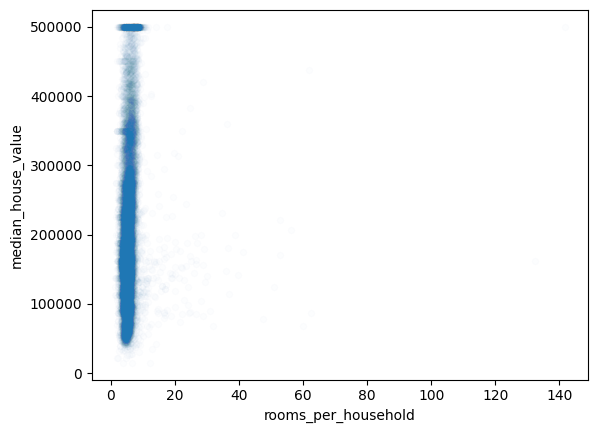

In [40]:
df_train.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.01)

# 머신러닝 알고리즘을 위한 데이터 준비

- 함수를 만들어 자동화 해야한다.
  - 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축
  - 관리하기 편해진다.

In [42]:
df_train = strat_train_set.drop("median_house_value", axis=1) # 훈련 세트를 위해 레이블 삭제
labels = strat_train_set["median_house_value"].copy()

### 데이터 정제
- total_bedroom null 값 채우기
  - 해당 구역 제거 (dropna)
  - 전체 특성(피쳐) 삭제 (drop)
  - 어떤 값으로 채운다(0,평균, 중앙값) (fillna)
    - ***계산한 중앙값을 저장해야한다!! 테스트 세트에도 적용시켜야 하기 때문에!!***

In [43]:
median = df_train["total_bedrooms"].median()
df_train["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

NameError: name 'sample_incomplete_rows' is not defined

In [44]:
# 누락된 값을 손쉽게 다루도록 해준다.
from sklearn.impute import SimpleImputer

In [45]:
imputer = SimpleImputer(strategy="median")

In [47]:
housing_num = df_train.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

In [52]:
housing_tr = pd.DataFrame(imputer.fit_transform(housing_num),\
                          columns=housing_num.columns,
                          index=housing_num.index)

In [56]:
sample_incomplete_rows = df_train[df_train.isnull().any(axis=1)].head()

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


#### ***sklearn의 설계 철학***
- 일관성
  - 추정기: (imputer 객체) 추정 자체는 fit 메서드에 의해 실행되고 하나의 매개변수로 하나의 데이터 셋만 전달한다.
  - 변환기: (imputer 같이 fit_transfrom() 메서드)
  - 예측기: (LinearRegression) 성능 측정을 위한 predict, score 메서드를 가진다.
- 검사 기능: 공개 인스턴스 변수로 접근 가능 (imputer.statistics_)
- 클래스 남용 방지: 넘파이 배열이나 사이파이 희소 행렬로 표현한다.
- 조합성: 기존의 구성 요소 최대한 재사용. pipeline 추정기를 쉽게 만들 수 있다.
- 합리적인 기본값: 기본 시스템을 빠르게 만들 수 있도록 지정해둠

### 텍스트와 범주형 특성 다루기
- ocean_proximity의 각 값은 카테고리를 나타내므로 텍스트에서 숫자로 변환하는 작업이 필요하다

In [59]:
from sklearn.preprocessing import OrdinalEncoder
housing_cat = df_train[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

- 이 표현 방식의 문제는 머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각하는 것이다.
  - 순서가 있는 경우 (bad ... good)
- 이 문제는 일반적으로 카테고리별 이진 특성을 만들어 해결한다.
  - 원-핫 인코딩

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False) #default 가 희소 행렬이다.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot
# housing_cat_1hot.toarray()

/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [64]:
print(cat_encoder.categories_,len(housing_cat_1hot[0]))

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)] 5


### 나만의 변환기
- 사이킷런의 기능과 매끄럽게 연동하기
- 사이킷런은 덕 타이핑을 지원하므로 fit , transform 메서드를 구현한 클래스를 만들면 된다.
- **np.c_: 가로로 합치기**
- **np.array()[:,1] : 1열의 정보를 가지고 온다.**

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
# rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    df_train.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        print('ix:: ',rooms_ix,households_ix)
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        # 해당 열만 가지고 온다.
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(df_train.to_numpy())

ix::  3 6


또한 `housing_extra_attribs`는 넘파이 배열이기 때문에 열 이름이 없습니다(안타깝지만 사이킷런을 사용할 때 생기는 문제입니다). `DataFrame`으로 복원하려면 다음과 같이 할 수 있습니다:

#### 넘파이 배열 데이터 프레임으로 변환

In [71]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### 특성 스케일
- 정규화 (min-max scaling)
  - 0~1 범위에 들게 하고
  - 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나누기
  - MinMaxScaler 변환기 (feature_range 로 범위 조정 가능)
- 표준화 (standardization)
  - 평균을 뺀 후 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다.
  - 범위의 상한과 하한이 없어서 문제가 될 수 도 있다.
  - 이상치에 영향을 덜 받는다.
  - StandardScaler 변환기 

### 변환 파이프 라인
- 마지막 단계엔느 변환기와 추정기를 모두 사용할 수 있고 그 외에는 모두 변환기여야 한다. (fit_transform을 가지고 있어야 한다.)
- 파이프라인의 fit을 호출하면 모든 변환기의 fit_transform()을 순서대로 호출한다.

In [89]:
df_train_num = df_train.drop("ocean_proximity", axis=1)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

ix::  3 6


#### **하나의 변환기로 각 열마다 적절한 변환을 적용해서 모든 열을 처리할 수 있게 하는법**

##### 방법 1
- 열 리스트 생성
- 각 튜플은 이름 , 변환기, 변환기가 적용될 열 이름

In [99]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df_train_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # 밀집 행렬 반환
        ("cat", OneHotEncoder(), cat_attribs), # 희소 행렬 반환
                                                # 최종으론 최종 행렬의 밀집 정도를 추정한다.
    ])

housing_prepared = full_pipeline.fit_transform(df_train)

ix::  3 6


In [95]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

##### 방법 2
- 방법 1의 결과랑 똑같다.
- 단지 사용자 정의 일뿐

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

# 모델 선택과 훈련 및 측정

In [101]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,labels)

LinearRegression()

In [106]:
# 훈련 샘플 몇 개를 사용해 전체 파이프라인을 적용
some_data = df_train.iloc[:5]
some_labels = labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

print("실제 값:", list(some_labels))

ix::  3 6
예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
실제 값: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


## RMSE 측정 (train_set)

#### 과소적합 확인

In [108]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

대부분 구역의 중간 주택 가격은 ```120_000``` ~ `265_000` 사이 인데 예측 오차가 `68_628`인것은 매우 만족 스럽지 못하다. 

--> `과소 적합`

--> 더 강력한 모델을 선택하거나, 훈련 알고리즘에 더 좋은 특성을 주입하거나, 모델의 규제를 감소시키는 것이다. (규제는 이 상황에선 안사용해서 제외)

#### 과대적합 확인

In [113]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse #0이 나오면 과대적합이다.

0.0

## 교차 검증을 사용한 평가
- 훈련세트를 더 작은 훈련 세트와 검증 세트로 나누고 그걸 통해 모델을 평가하는 방법
- cv =10 으로 줘서 결정 트리 모델을 10번 훈련하고 평가하는데 매번 다른 폴드를 선택(1개)해 평가에 사용하고 나머지 9개 폴드는 훈련에 사용한다.
- 10개의 평가 점수가 담긴 배열이 결과가 된다.

In [115]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, labels,
                         scoring="neg_mean_squared_error", cv=10)
#
tree_rmse_scores = np.sqrt(-scores)

- 사이킷런의 교차 검증 기능은 scoring 매개변수에 (낮을수록 좋은) 비용 함수가 아니라 (클수록 좋은) 효용 함수를 기대한다
- MSE의 반대값을 줘서 -scores로 부호를 바꿔야한다....??

In [117]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
평균: 71629.89009727491
표준 편차: 2914.035468468928


## 앙상블 모델 이용

In [119]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, labels)

RandomForestRegressor(random_state=42)

In [94]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [121]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균: 50435.58092066179
표준 편차: 2203.3381412764606


- 훈련세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮으므로 이 모델도 여전히 훈련 세트에 과대 적합 되어 있다.
    - 과대 적합 해결법은 모델을 간단히 하거나, 제한(규제), 더 많은 훈련 데이터를 모으는 것이다.

# 모델 세부 튜닝

## 그리드 탐색
- 비교적 적은 수의 조합을 탐구할 때 괜찮다.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 다섯 개의 폴드로 훈련하면 총 (12+6)*5=90번의 훈련이 일어납니다.
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

## 랜덤 탐색
- 하이퍼 파라미터 탐색 공간이 커지면 사용

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7071466e48>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7071e76780>},
                   random_state=42, scoring='neg_mean_squared_error')

In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


## 앙상블 방법

## 최상의 모델과 오차 분석
- 모델이 예측을 만들기 위한 각 특성의 상대적인 중요도
- 덜 중요한 특성들을 제외할 수 있다.

In [105]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [106]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # 예전 방식
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

## 테스트 세트로 평가
- 추정값도 알 수 있게 된다

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# 추가

## 전체 파이프라인

In [112]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

## 모델 저장

In [ ]:
# import joblib
# joblib.dump(mymodel, 'test.pkl')
# my_model_load = joblib.load(test.pkl)